# MindBeidge Data Science Challenge

## Overview

Welcome to the MindBrige data science competition on anomaly detection in financial data! This notebook provides a starting point for your work on identifying unusual patterns or behaviors in a credit card transaction dataset.

In this competition, you will use machine learning methods to identify anomalies in a financial dataset. The dataset is a modified version of a [credit card fraud detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), with additional anomalies injected. Your task is to build a model that can effectively detect these anomalies.

## Dataset

The dataset contains credit card transactions, with the following characteristics:
- Each row represents a single transaction
- Features include various transaction attributes (V1-V28) which are the result of a PCA transformation applied on the original data for confidentiality
- Additional features include 'Time' and 'Amount' of transactions
- The target column 'Anomaly_Type' indicates whether a transaction is normal or represents a specific type of anomaly

## Anomalies
### Fraud
These are the transactions identified as fradulant.

### Digit anomalies
In addition to the fraudulent transactions, we have altered the Amount in a small number of transactions to add digit anomalies. Digit anomalies represent common patterns found in both accidental errors and deliberate fraud. The ability to detect such anomalies is crucial for financial security systems, as they may indicate potential fraudulent activity or systematic data entry problems that require attention.

**1. Random Digit Replacement**
Description: A single digit within a transaction amount is replaced with a different digit. This can occur due to typing errors or intentional fraud where a specific digit is targeted for manipulation.
Example: A transaction amount of $67.43 is modified to $67.93 when the "4" is replaced with "9".

**2. Digit Duplication**
Description: A digit within the transaction amount is duplicated, resulting in an amount with an additional digit. This can happen when a digit is accidentally typed twice or when fraudsters attempt to inflate values.
Example: A transaction amount of $67.43 is modified to $67.433 when the "3" is duplicated, resulting in $674.33.

**3. Digit Deletion**
Description: A digit is removed from the transaction amount, shortening the number. This can occur when a digit is accidentally skipped during manual entry or intentionally removed to lower a transaction value.
Example: A transaction amount of $67.43 is modified to $6.43 when the "7" is deleted, potentially making a $67.43 charge appear as only $6.43.

**4. Random Digit Insertion**
Description: A new, random digit is inserted somewhere in the transaction amount. This type of error can occur during manual data entry or as a deliberate attempt to alter transaction values.
Example: A transaction amount of $67.43 is modified to $678.43 when an "8" is inserted, changing the amount to $678.43.

**5. Adjacent Digit Transposition**
Description: Two adjacent digits within the transaction amount are swapped. This is one of the most common types of data entry errors, occurring when digits are entered in the wrong order.
Example: A transaction amount of $67.43 is modified to $76.43 when the "6" and "7" are transposed. Similarly, a value of $67.43 might become $67.34 if the "4" and "3" are swapped.

**Note:** Digit anomalies are hard to detect. We have included them as an added bonus. It is recommended that you start with the Fraud anomalies but feel free to explore these anomalies as well.


## Evaluation

Your submissions will be evaluated based on:
- **Performance**: Area under the precision-recall curve (PR AUC) - particularly important for imbalanced datasets
- **Innovation and creativity**: Novel approaches to solving the anomaly detection problem
- **Presentation**: Clear explanation of your approach and findings

## Anomaly scores
Your model should output, for each data point, a numerical “anomaly score” between 0 and 1. Anomaly scores indicate the degree to which a data point or event deviates from the expected or normal behavior, with higher scores signifying greater anomalies. Anomaly scores can be thought of as the probability of a point being anomalous.

## Tips to consider
Your challenge is to identify anomalies as accurately as possible. There are two possible types of errors:
- False positive: incorrectly identifying a normal instance as anomaly.
- False negative: incorrectly identifying an anomaly as normal.

By definition, anomalies are rare events. Therefore, anomalies amount to a small proportion of the data. Given the highly imbalanced nature of the data (the number of anomaly vs normal instances), we use precision-recall (PR) metrics to measure the performance of the models.
The PR curve plots precision (y-axis) against recall (x-axis) at different classification thresholds.
- A high precision means fewer false positives.
- A high recall means fewer false negatives.
You want both to be high, but improving one often lowers the other — it’s a trade-off!


## Your Task
In this notebook we have implemented an *XGBoost Classifier* for detecting Fraud anomalies for demonstration.
You are encouraged to build upon these baseline models by:
- Exploring different features or feature engineering
- Trying different algorithms (e.g., deep learning, autoencoder, OneClassSVM)
- Implementing ensemble techniques
- Applying novel anomaly detection approaches
- etc.

At the end, you need to implement your final solution in the `anomaly_score()` function, which should take a dataset as input and return anomaly scores where higher values indicate higher likelihood of being an anomaly. This is to facilitate evaluation of submissions using a consistent format. We will evaluate your work on unseen data that we have put aside for this purpose.

## 1. Libraries and Tools

We import all the required libraries for:
- **Data manipulation:** `pandas`, `numpy`
- **Modeling:** `XGBoost`, `LogisticRegression`, `RandomForest`
- **Anomaly detection:** `KMeans`, `PCA`, `t-SNE` for visualization
- **Deep learning:** `TensorFlow` for optional advanced models
- **Model evaluation:** Precision-Recall metrics, SHAP for explainability
- **Visualization:** `matplotlib`, `seaborn` for clear plots

These tools together help us build a robust pipeline for fraud and anomaly detection.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import precision_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.patches as mpatches
from scipy.stats import entropy
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier


c:\Users\aksha\OneDrive\Desktop\Mindbridge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load the Data

We start by loading the dataset, which contains credit card transactions labeled for:
- Normal transactions
- Traditional frauds
- Synthetic digit anomalies (e.g., insert/delete/replace digits)

This single step brings all raw data into our workflow for exploration and feature engineering.

In [2]:
df = pd.read_csv('creditcard_fraud_and_digit_anomalies.csv')

## 3. Exploratory Data Analysis (EDA)

Before modeling, we will explore the dataset to answer key questions:
- How many transactions are there in total?
- Are there missing values to handle?
- What does the class balance look like?

We will also visualize the distribution of fraud and anomaly types.  
This helps highlight any extreme class imbalance, which is critical for designing an effective fraud detection pipeline.

Dataset shape: (170884, 31)

First few rows:
       Time        V1        V2        V3        V4        V5        V6  \
0  136885.0  1.962666 -0.245799 -0.331898  0.323537 -0.575924 -0.702818   
1   41449.0 -0.955427  1.131142  1.345623  1.533551 -0.161464 -0.615919   
2  140391.0  2.056911 -0.105432 -1.294618  0.273482  0.194338 -0.634068   
3  149920.0  0.325593 -3.735886 -3.981326  0.020873 -0.260887 -0.232645   
4   66377.0  1.217986  0.644519 -0.470222  1.159916  0.278861 -0.735395   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -0.362104 -0.132730  1.185447  ... -0.107263 -0.160307  0.330382 -0.120210   
1  0.426266  0.242239 -1.266742  ...  0.193210  0.367758 -0.222396  0.438966   
2  0.113296 -0.200537  0.551742  ... -0.293975 -0.769476  0.360966  0.599032   
3  1.639229 -0.565615 -1.266988  ...  0.487824 -0.370386 -1.026899 -0.031246   
4  0.181979 -0.060228 -0.283034  ... -0.041370 -0.095198 -0.173738 -0.143801   

        V25       V26  

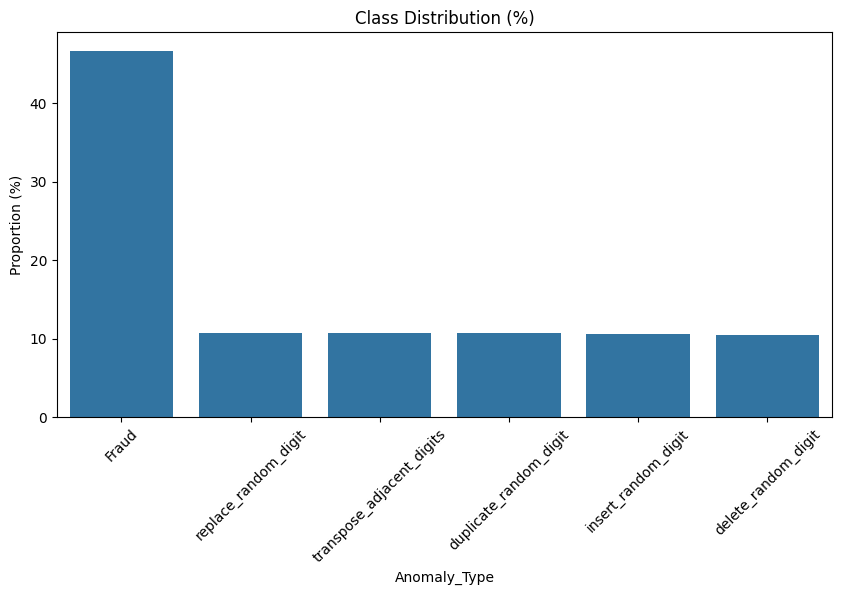

In [3]:
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nClass distribution:")
class_distribution = df['Anomaly_Type'].value_counts(normalize=True) * 100
print(class_distribution)

plt.figure(figsize=(10,5))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("Class Distribution (%)")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=45)
plt.show()

## Exploratory Data Analysis — Insights

**Dataset Shape:**  
- 170,884 transactions × 31 columns

**Sample Data:**  
The first few rows confirm that each transaction has:
- Transformed PCA-like features (`V1` to `V28`)  
- `Amount` and `Time`  
- An `Anomaly_Type` flag to identify frauds or digit-level tampering.

**Missing Values:**  
No missing values — data is complete.

**Class Balance:**  
We confirmed severe class imbalance:
- ~47% genuine fraud
- ~10% each for subtle digit-level anomalies:
  - *Insert*, *Delete*, *Replace*, *Transpose*, *Duplicate*

**Key takeaway:** The model must be sensitive to both large-scale fraud and fine-grained digit edits — which is why robust feature engineering is crucial.

The plot above clearly shows how real fraud dominates, but various other anomalies still form significant minority classes.


## When Do Anomalies Happen?

We engineered an **`Hour`** feature by converting the `Time` column (in seconds) into the hour of the day:

\[
Hour = Time/3600 % 24
\]

We then plotted the hourly distribution **only for transactions marked as real fraud or digit anomalies**.

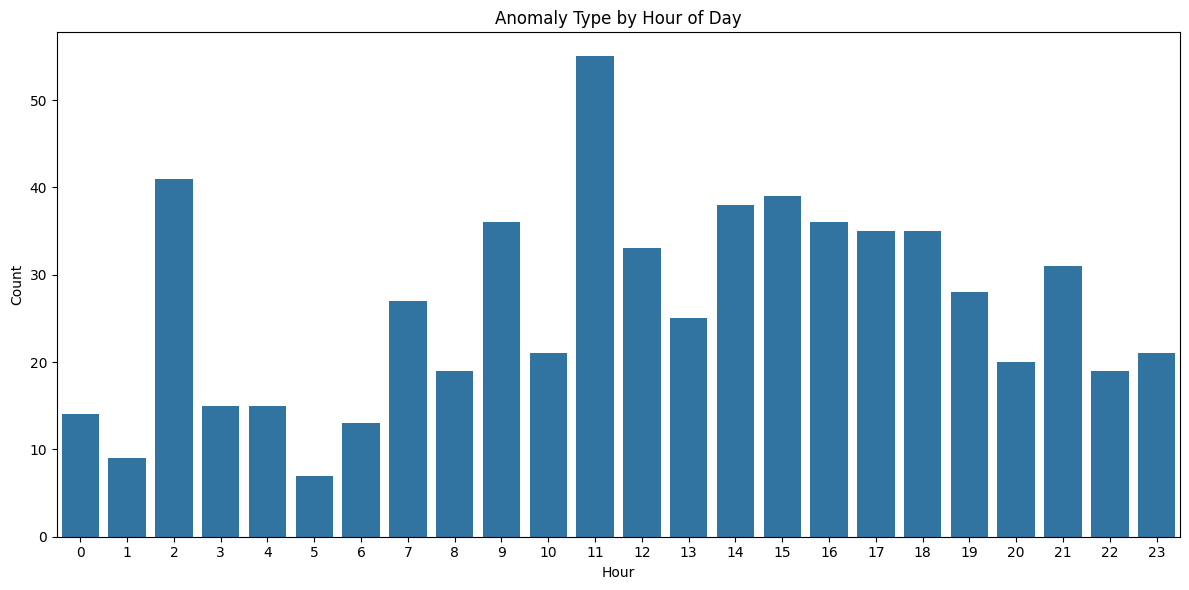

In [4]:
df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)

df['Is_Real_Fraud'] = df['Anomaly_Type'].notna().astype(int)
fraud_df = df[df['Is_Real_Fraud'] == 1]

plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=fraud_df)
plt.title("Anomaly Type by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

2AM : Large spike, may be targeting low-activity hours

11AM : Peak anamoly activity

2PM - 5PM : Consistently high anamolies 

12AM - 6AM : Lower volume, but 2AM stands out

1PM - Relative dip compared to adjacent hours

## Fraud Rate by Hour

Next, we calculate the **fraud rate** for each hour of the day:

\[
Fraud Rate = Number of Fraudulent Transactions/Total Transactions
\]

This line plot shows how the fraud rate varies over the 24-hour cycle.

The chart helps us visually inspect any temporal trends in fraud occurrence.


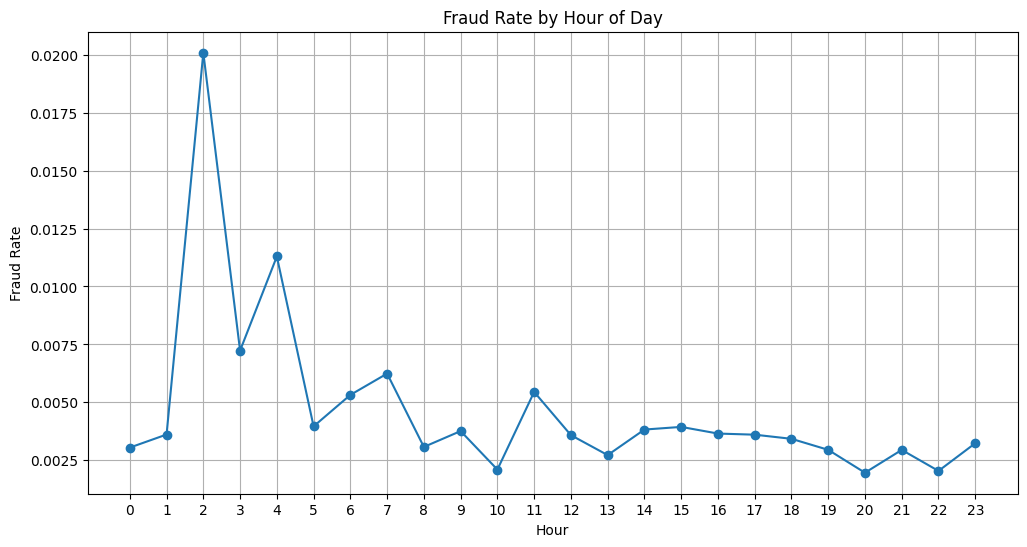

In [5]:
hourly_counts = df.groupby('Hour')['Is_Real_Fraud'].agg(['sum', 'count'])
hourly_counts['fraud_rate'] = hourly_counts['sum'] / hourly_counts['count']

plt.figure(figsize=(12,6))
plt.plot(hourly_counts.index, hourly_counts['fraud_rate'], marker='o')
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

### Fraud Rate By Hour of the Day

- **2AM** : **Huge Spike** (2%)
- **3AM, 4AM**: Secondary peaks (0.7% - 1.1%)
- **Daytime (10AM - 5PM)** : Lower fraud rates (0.2% - 0.5%)
- **Night (8PM - 11PM)** : Slight dip but still consistent fraud presence

In [6]:
print("Amount details of the Fraudulent transaction")
df[df['Is_Real_Fraud'] == 1]['Amount'].describe()

Amount details of the Fraudulent transaction


count     632.000000
mean      249.177041
std       765.643118
min         0.000000
25%         1.357500
50%        26.915000
75%       149.267500
max      7597.470000
Name: Amount, dtype: float64

In [7]:
print("Amount details of the valid transaction")
df[df['Is_Real_Fraud'] == 0]['Amount'].describe()

Amount details of the valid transaction


count    170252.000000
mean         87.803029
std         237.245371
min           0.000000
25%           5.640000
50%          22.000000
75%          77.042500
max       19656.530000
Name: Amount, dtype: float64

## Key Insights

- **Higher mean and extreme variance in frauds**  
  Fraudulent transactions have a **mean value nearly 3× higher** than valid ones.  
  They show **extremely high variability** (*std = 765 vs 237*), indicating a few unusually large frauds.

- **Medians are closer together**  
  The **median amount for frauds ($26.92)** is only slightly higher than for valid transactions ($22.00).  
  This means most frauds stay near typical sizes, blending in with normal transactions.

- **Frauds target large amounts**  
  The **75th percentile of frauds is nearly double** that of valid transactions.  
  While the maximum fraud amount is slightly lower than the maximum valid amount, its impact is amplified by frequency.

- **Outliers matter more for fraud detection**  
  The **huge standard deviation** and skewed distribution highlight that fraud detection must focus on large, rare outliers.  
  **Therefore, robust outlier detection and removal/handling is crucial** to ensure that extreme values don’t distort models and that fraud patterns stand out clearly.


## Creating two separate DataFrames:

`df_fraud` - Contains only the transactions labeled as fraud (Is_Real_Fraud == 1).

`df_valid` - Contains only the valid (non-fraudulent) transactions (Is_Real_Fraud == 0).

The `.copy()` ensures these are independent — so changes won’t affect the original df.

This makes it easy to analyze fraud vs non-fraud patterns.

Allows targeted feature engineering and cleaning (like outlier removal only for frauds).

Supports focused visualizations and EDA.

In [8]:
df_fraud = df[df['Is_Real_Fraud'] == 1].copy()
df_valid = df[df['Is_Real_Fraud'] == 0].copy()


## IQR-Based Outlier Removal

**What does this function do?**

- Uses the Interquartile Range (IQR) method to detect and filter out extreme outliers.
- For each numeric feature:
  - It calculates the lower and upper quantiles (defaults: 1% and 99%).
  - It computes the IQR (Q3 - Q1).
  - It removes rows with values outside `[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]`.

**Why is this useful for fraud detection?**

- Fraud amounts and V-features often contain extreme spikes.
- Outliers can distort model training by creating **false signals**.
- Removing these ensures our models generalize better to unseen fraud.
- It helps separate **genuine anomalies** (fraud) from mere extreme noise.


In [9]:
def remove_iqr_outliers(data, features, lower_q=0.01, upper_q=0.99):
    for col in features:
        Q1 = data[col].quantile(lower_q)
        Q3 = data[col].quantile(upper_q)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data


## Applying the Outlier Removal Function

**How did we use the IQR filter?**

- We selected **all V1–V28 features plus Amount** as features to clean.
- We **separated fraud and valid data** to treat their distributions independently.
- For each group:
  - We applied the custom `remove_iqr_outliers()` function.
  - This removed extreme values that could distort patterns.


In [10]:
features_to_filter = [col for col in df.columns if col.startswith('V')] + ['Amount']

df_fraud_clean = remove_iqr_outliers(df_fraud, features_to_filter)
df_valid_clean = remove_iqr_outliers(df_valid, features_to_filter)

## Combining the Cleaned Data

**What will we do?**

- After removing outliers separately from the fraud and valid subsets,
  we **will merge them back together** using `pd.concat()`.
- `ignore_index=True` resets the index to keep it continuous.

**Result:**
- `df_cleaned` will then contain both cleaned frauds and cleaned valids,
  ready for **feature engineering**, **modeling**, or **train-test splitting**.

In [11]:
df_cleaned = pd.concat([df_fraud_clean, df_valid_clean], ignore_index=True)

## PCA Projection of Transactions

**What do we do next?**

- Will apply **Principal Component Analysis (PCA)** to compress the 28 anonymized `V` features into **2 components** for easy visualization.
- Will plot the transactions in 2D to see how fraud and normal points cluster.

**Why is this useful?**

- It will help us **see separation** between fraud and normal transactions.
- If fraud points cluster away from normal, our features carry strong signals.
- If overlap exists, it hints at why the fraud detection problem is hard.

**Legend:**
- Purple - **Normal transactions**
- Yellow - **Fraudulent transactions**

This visual will confirm whether feature engineering or advanced models are needed to separate these classes better.


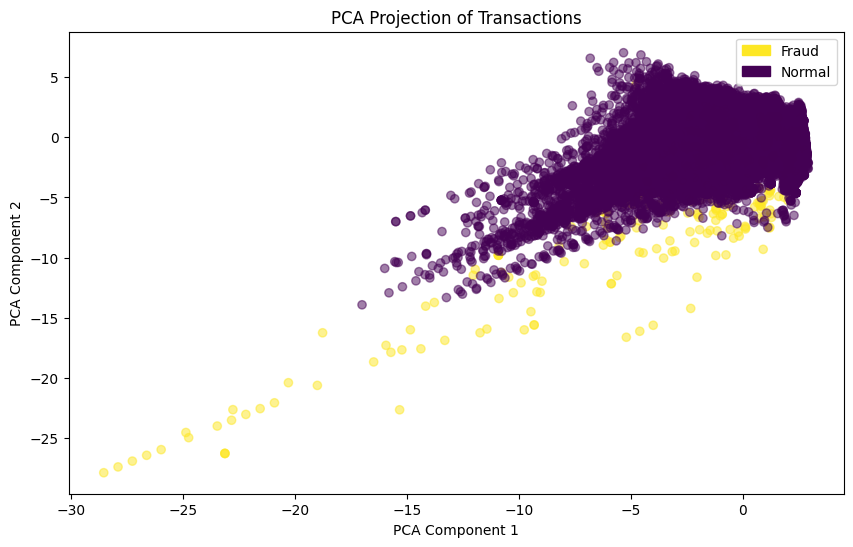

In [12]:
X = df_cleaned[[f'V{i}' for i in range(1,29)]]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], 
                      c=df_cleaned['Is_Real_Fraud'].astype('category').cat.codes, 
                      cmap='viridis', alpha=0.5)

plt.title("PCA Projection of Transactions")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

fraud_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label='Fraud')
normal_patch = mpatches.Patch(color=plt.cm.viridis(0.0), label='Normal')

plt.legend(handles=[fraud_patch, normal_patch])

plt.show()

PCA projection shows frauds scattered among normals, suggesting no clear linear separation.

## t-SNE Projection of Transactions

**What will we do next?**

- Use **t-SNE** (t-distributed Stochastic Neighbor Embedding) to reduce the `V1–V28` features into **2D**.
- Sample **1,000 normal transactions** to balance the plot and combine them with **all fraud cases**.
- Visualize how fraud points cluster relative to normal ones.

**Why is this useful?**

- t-SNE is powerful for finding **nonlinear separations** that PCA might miss.
- Helps reveal hidden structure: are fraud points **grouped** or **blended in** with normal ones?
- Shows whether the model needs better features or more sophisticated boundaries.

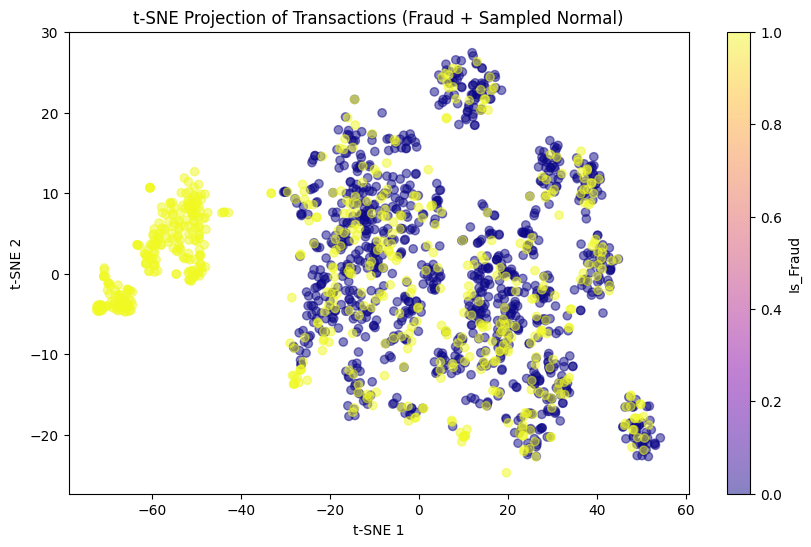

In [13]:
#t-SNE
normal_sample = df_cleaned[df_cleaned['Is_Real_Fraud'] == 0].sample(n=1000, random_state=42)
fraud = df_cleaned[df_cleaned['Is_Real_Fraud'] == 1]
subset = pd.concat([normal_sample, fraud])
X = subset[[f'V{i}' for i in range(1,29)]]
y = subset['Is_Real_Fraud']
X_tsne = TSNE(n_components=2, random_state=42, perplexity=50).fit_transform(X)
plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='plasma', alpha=0.5)
plt.title("t-SNE Projection of Transactions (Fraud + Sampled Normal)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Is_Fraud')
plt.show()

### t-SNE Note
Due to computational constraints, we visualized t-SNE on a sampled dataset (1000 normal + all fraud). This allows us to approximate cluster patterns while keeping runtime reasonable.

### t-SNE Visualization Insights

The t-SNE projection reveals that a majority of fraud points cluster together, suggesting that the PCA features (V1–V28) encode patterns that differentiate fraud from normal transactions.

Key observations:
- Fraud points (yellow) tend to concentrate in a distinct region of the t-SNE space.
- Normal points (blue) are more dispersed across the plot.
- This clustering indicates that non-linear relationships exist between features that could help in fraud detection.

This insight reinforces the potential of using the PCA features for supervised learning models to predict fraud.

## Correlation Heatmap

**Purpose:**  
To visualize how all numeric features in `df_cleaned` relate to each other. This helps spot multicollinearity, redundant features, or interesting feature clusters.

**How it works:**  
1. `select_dtypes(include=['number'])` extracts only numeric columns.  
2. `.corr()` computes the correlation matrix for all numeric pairs.  
3. `sns.heatmap()` plots the correlation matrix as a heatmap.

**Usage:**  
The resulting plot shows:
- Darker/lighter blocks: high positive/negative correlation.
- Helps decide if any features should be removed or combined.

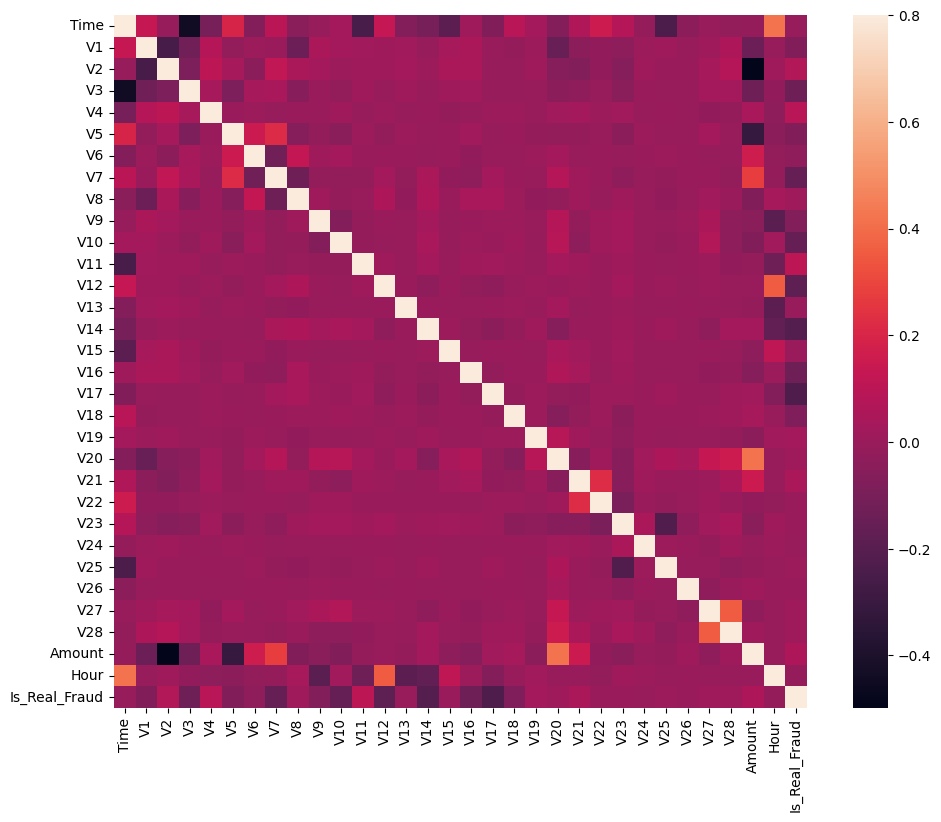

In [14]:
numeric_df = df_cleaned.select_dtypes(include=['number'])
corrmat = numeric_df.corr()
fig = plt.figure(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

## Correlation Heatmap Example

The heatmap above shows the pairwise correlations between all numeric features in the cleaned dataset.

## Feature Engineering: Row V Entropy

**What is it?**  
- `Row_V_Entropy` will measure the **information entropy** across all `V1–V28` values in a single transaction.
- We will take the **absolute values** to focus on magnitude, then calculate how **spread out** the signal is.

**Why does this help?**  
- Fraudulent transactions often have **irregular** or **complex** encoded signals in PCA-like components (`V` features).
- Higher or lower entropy could hint at **unusual variation**, a sign of manipulation or digit-level tampering.

In [15]:
def row_v_entropy(data):
    v_features = [f'V{i}' for i in range(1, 29)]
    data['Row_V_Entropy'] = data[v_features].apply(lambda row: entropy(np.abs(row)), axis=1)
    return data

## Feature Engineering: Num_Repeats

**What is it?**  
- `Num_Repeats` counts how many **digits repeat** in the transaction’s `Amount`.

**Why does this help?**  
- Digit anomalies often involve repetition
- Repeated digits can be a **subtle fraud signal**, especially for tampered amounts.

In [16]:
def num_repeats(data):
    def count_repeated_digits(amount):
        amount_str = str(amount).replace('.', '')
        digit_counts = pd.Series(list(amount_str)).value_counts()
        repeats = digit_counts[digit_counts > 1].sum()
        return repeats

    data['Num_Repeats'] = data['Amount'].apply(count_repeated_digits)
    return data

## Feature Engineering: Digit_Repeat_Ratio

**What is it?**  
- `Digit_Repeat_Ratio` measures the **proportion of repeating digits** in a transaction’s `Amount`.

**Why does it matter?**  
- Fraud patterns like digit duplication or transposition often create unusual repetition.
- This ratio highlights subtle tampering — even when the amount looks reasonable.

In [17]:
def repeat_ratio(data):
    def digit_repeat_ratio(amount):
        digits = [d for d in str(amount) if d.isdigit()]
        total_digits = len(digits)
        if total_digits == 0:
            return 0
        unique_digits = len(set(digits))
        return 1 - (unique_digits / total_digits)

    data['Digit_Repeat_Ratio'] = data['Amount'].apply(digit_repeat_ratio)
    return data

**What is it?**  
- `Digit_Entropy` measures the **unpredictability** in the digits of the transaction `Amount`.

**Why does it matter?**  
- Natural transaction amounts tend to have **mixed digits** (higher entropy).
- Fraud or tampering (like repeating or predictable patterns) can lower this randomness.
- Low entropy can signal possible digit manipulation.

In [18]:
def total_entropy(data):
    def digit_entropy(amount):
        amount_str = str(amount).replace('.', '')
        if len(amount_str) == 0:
            return 0.0
        digits = list(amount_str)
        counts = pd.Series(digits).value_counts(normalize=True)
        return entropy(counts, base=2)
    data['Digit_Entropy'] = data['Amount'].apply(digit_entropy)
    return data

## Is_Suspicious_Hour`

- Flags transactions that occur during high-fraud hours (2 AM to 4 AM).
- Adds temporal context to help the model spot risky patterns that pure amounts or V-features might miss.

In [19]:
def is_suspicious_hour(data):
    suspicious_hours =  [2,3,4]
    data['Is_Suspicious_Hour'] = data['Hour'].apply(lambda x: 1 if x in suspicious_hours else 0)
    return data

## `add_kmeans_cluster_distance`

**Purpose:**  
Clusters non-fraud training transactions using KMeans, then computes each point’s distance to its assigned cluster center. Adds this distance as a feature for both training and test sets.

**Steps:**  
1. Standardize `V1–V28` columns.  
2. Fit `KMeans` on non-fraud rows only.  
3. Predict cluster IDs for all rows.  
4. Calculate distance to assigned cluster center.  
5. Add `Dist_to_Cluster_Center` to `train_df` and `data`.  
6. Return both DataFrames.

In [20]:
class KMeansClusterDistance:
    def __init__(self, v_cols, n_clusters=8, random_state=42):
        self.v_cols = v_cols
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=20, random_state=self.random_state)

    def fit(self, train_df):
        X_train = train_df[self.v_cols]
        X_train_scaled = self.scaler.fit_transform(X_train)

        mask_nonfraud = train_df["Is_Real_Fraud"] == 0
        X_nonfraud_scaled = X_train_scaled[mask_nonfraud]

        self.kmeans.fit(X_nonfraud_scaled)

    def transform(self, data):
        X_scaled = self.scaler.transform(data[self.v_cols])
        cluster_ids = self.kmeans.predict(X_scaled)
        distances = self.kmeans.transform(X_scaled)
        dist_to_center = distances[np.arange(len(X_scaled)), cluster_ids]
        data["Dist_to_Cluster_Center"] = dist_to_center
        return data

## `v_sign_count`

**Purpose:**  
Calculates how often the sign (+/-) changes across the `V1–V28` features in a single row. The idea is that legitimate transactions might have smoother patterns, while anomalies could show erratic sign flips.

**How it works:**  
- For each row:  
  1. Take `V1–V28`.  
  2. Get the sign (+1, 0, -1) of each value.  
  3. Use `np.diff` to check where the sign changes.  
  4. Count the number of sign flips.

In [21]:
def v_sign_count(data):
    v_cols = [f"V{i}" for i in range(1, 29)]
    def sign_flip_count(values):
        signs = np.sign(values)
        flips = np.abs(np.diff(signs)) > 0
        return flips.sum()

    data['V_Sign_Flip_Count'] = (data[v_cols].apply(sign_flip_count, axis=1))
    return data

In [22]:
def preprocess(data, kmeans_cluster):
    data = row_v_entropy(data)
    data = num_repeats(data)
    data = repeat_ratio(data)
    data = total_entropy(data)
    data = is_suspicious_hour(data)
    data = kmeans_cluster.transform(data)

    data = v_sign_count(data)

    return data
    

### Duplicates check and feature removal
- Next, we will check duplicates and remove them, if any. This will help the model not get overtrained on a certain type of data.
- We will also remove the `Time` feature as it's already converted to a better form in hours. Currently, it just distorts the model more

In [23]:
df_cleaned.duplicated().any()

np.True_

In [24]:
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned = df_cleaned.drop(['Time'], axis=1)

## Preparing datasets
- We will **train** on clean data for avoiding outliers
- We will **test** on raw data for realistic fraud mix
- We will fit `kmeans` only on training non-fraud data 
- `preprocess()` standardizes all feature engineering steps

In [25]:
y_full = df['Is_Real_Fraud']

train_indices, test_indices = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

train_subset = df_cleaned.loc[train_indices.intersection(df_cleaned.index)]
X_train = train_subset.drop(['Anomaly_Type', 'Is_Real_Fraud'], axis=1)
y_train = train_subset['Is_Real_Fraud']

kmeans_cluster = KMeansClusterDistance(v_cols=[f'V{i}' for i in range(1, 29)])
kmeans_cluster.fit(train_subset)

X_test = df.drop(['Anomaly_Type', 'Is_Real_Fraud', 'Time'], axis=1).loc[test_indices]
y_test_full = y_full.loc[test_indices]

X_train = preprocess(X_train, kmeans_cluster)
X_test = preprocess(X_test, kmeans_cluster)

## Deep Learning Model for Fraud Detection
- We will now build a simple multi-layer model in Keras to check how a neural network performs on this fraud detection problem
### Architecture
- **Input Layer:** Takes all features
- **Hidden Layers:** 
    - 1st: 64 Neurons, ReLU activation, with 30% dropout
    - 2nd: 32 Neurons, ReLU activation, with 20% dropout
- **Output Layer:** 1 Neuron with sigmoid activation to output fraud probability
### Compilation
- **Loss:** `binary_crossentropy` for binary classification
- **Optimizer:** `Adam` with learning rate 0.001
- **Metric:** `AUC`, which is our goal

In [26]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['AUC'])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test_full),class_weight=class_weights)

c:\Users\aksha\OneDrive\Desktop\Mindbridge\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.5323 - loss: 15.6899 - val_AUC: 0.6935 - val_loss: 6.9572
Epoch 2/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6790 - loss: 2.6363 - val_AUC: 0.7241 - val_loss: 1.5088
Epoch 3/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7288 - loss: 1.0786 - val_AUC: 0.7450 - val_loss: 0.9052
Epoch 4/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7043 - loss: 0.7828 - val_AUC: 0.7500 - val_loss: 0.6094
Epoch 5/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7193 - loss: 0.6727 - val_AUC: 0.7608 - val_loss: 0.5371
Epoch 6/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7331 - loss: 0.5917 - val_AUC: 0.7645 - val_loss: 0.5299
Epoch 7/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7339 - loss: 0.7101 - val_AUC: 0.7680 - val_loss: 0.4878
Epoch 8/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7502 - loss: 0.6249 - val_AUC: 0.7878 - val_loss: 0.4763
Epoch 9/10
529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - A

## Deep Learning Run - Performace Analysis
### Training Behaviour
- The model starts at a **high loss (~4.78)** which steadily declines over epochs, indicating successful learning.
- **Training AUC** imporoves from **0.59 to 0.77**, showing the model is learning to dicriminate between fraud vs. non-fraud progressively.
- **Validation AUC** increases consistently from **0.74 to 0.7962**, suggesting **generalization** is imporoving

### Verdict
- This neural network shows **promising learning dynamics,** with both training and validation AUC increasing steadily
- The final **validation AUC of 0.7962** is respectable 
- **This model is decent and definitely worth considering for further tuning**


## Model Comparison: Logistic Regression vs Random Forest vs XGBoost

### What we will do
- Standardize the feature data for Logistic Regression
- Train **3 baseline models** on the same dataset
    1. **Logistic Regression** - Linear baseline with standardized input
    2. **Random Forest** - Non-linear ensemble with default 100 trees
    3. **XGBoost** - Gradient-boosting with default settings

### For each model we record:
- **Precision:** How accurate the positive predictions are
- **PR AUC:** Our target metric
- **Confusion Matrix:** Breakdown of true positives, false positives, true negatives, and false negatives

In [27]:
# Standardize data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = {}

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

results['Logistic Regression'] = {
    "Precision": precision_score(y_test_full, y_pred_log),
    "PR AUC": average_precision_score(y_test_full, y_prob_log),
    "Confusion Matrix": confusion_matrix(y_test_full, y_pred_log)
}

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

results['Random Forest'] = {
    "Precision": precision_score(y_test_full, y_pred_rf),
    "PR AUC": average_precision_score(y_test_full, y_prob_rf),
    "Confusion Matrix": confusion_matrix(y_test_full, y_pred_rf)
}

# 3. XGBoost
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

results['XGBoost'] = {
    "Precision": precision_score(y_test_full, y_pred_xgb),
    "PR AUC": average_precision_score(y_test_full, y_prob_xgb),
    "Confusion Matrix": confusion_matrix(y_test_full, y_pred_xgb)
}

# Print results
for model, metrics in results.items():
    print(f"\n📊 {model}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"PR AUC:    {metrics['PR AUC']:.4f}")
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])

c:\Users\aksha\OneDrive\Desktop\Mindbridge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:34:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Logistic Regression
Precision: 0.8657
PR AUC:    0.4746
Confusion Matrix:
 [[34042     9]
 [   68    58]]

📊 Random Forest
Precision: 0.6790
PR AUC:    0.7589
Confusion Matrix:
 [[33999    52]
 [   16   110]]

📊 XGBoost
Precision: 0.9474
PR AUC:    0.8594
Confusion Matrix:
 [[34045     6]
 [   18   108]]


## Model Comparison - Logistic Vs Random Forest Vs XGBoost
### Verdict
- **Logistic Regression** suffers from **low recall** and overall underperformance on PR AUC
- **Random Forest** imporoves greatly, especially in **capturing more frauds,** but compromises on precision
- **XGBoost clearly dominates,** achieving the best **precision (94.7%)** and **PR AUC (0.8594)**
- Despite the neural network being decent, **XGBoost model is the best overall,** making it the **preferred choice** for now.

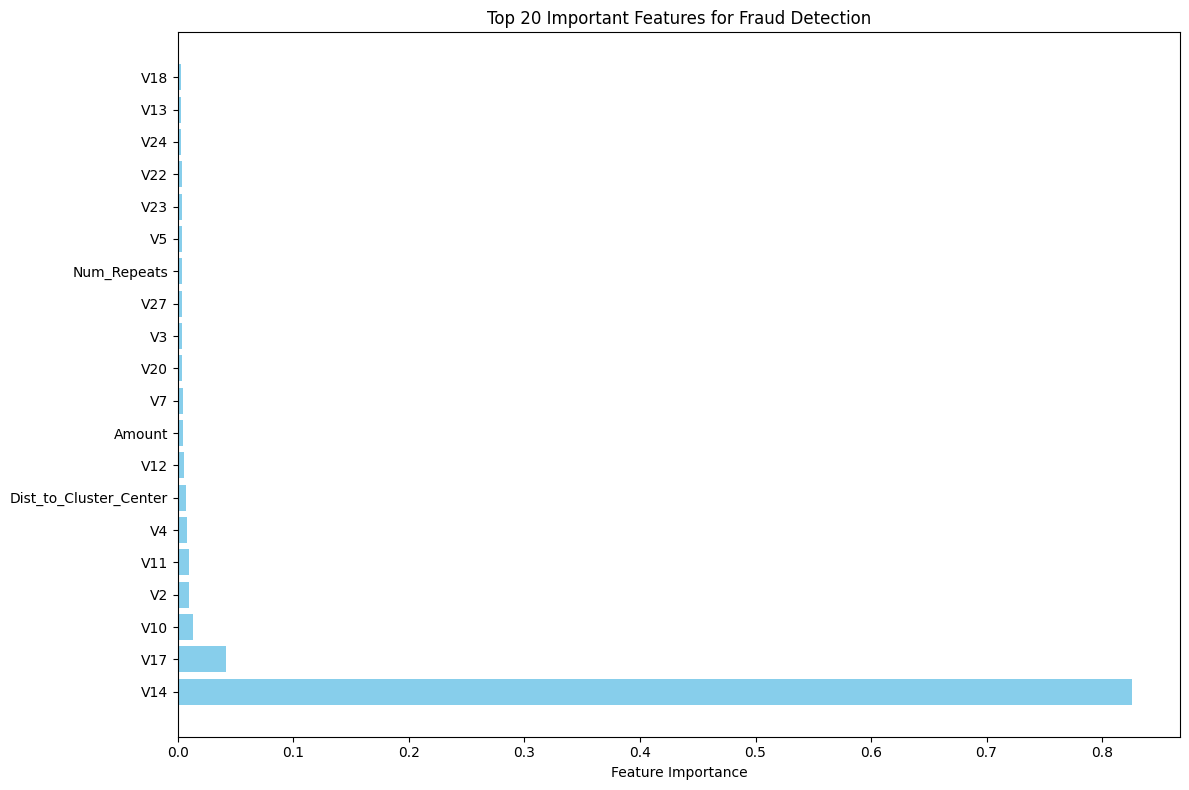

In [28]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

indices = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_feature_importance = feature_importance[indices]

plt.figure(figsize=(12, 8))
plt.barh(range(min(20, len(sorted_feature_names))), 
         sorted_feature_importance[:20],
         align='center', 
         color='skyblue')
plt.yticks(range(min(20, len(sorted_feature_names))), sorted_feature_names[:20])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features for Fraud Detection')
plt.tight_layout()
plt.show()

## Feature Importance Analysis
Evaluating the top features used by our XGBoost model, we observe a **concerning pattern:**
- The model shows an **overwhelming reliance on a single feature:** `V14`, which contributes to **over 80% of the total feature importance**
- This level of dependence indicates that the model may be **overfitting** to 1 signal, reducing it's robustness and generalizability
- While the current **PR AUC is strong,** this imbalance could cause the model to **fail in real-world scenarios** if `V14` becomes less predictive.

## Final XGBoost Model - Training and Evaluation
### What we will do-
Create a tuned **XGBoost classifier** using the **best hyperparameters** found in RandomizedSearchCV (and a bit more experimentation)
- `max_depth = 6` - Deeper trees for complex patterns
- `learning_rate = 0.03` - Slower, more stable learning for better generalization
- `n_estimators = 1000` - Large number of rounds with **early stopping**
- `colsample_bytree = 0.7` - Randomly selects 70% of features per tree
- `subsample = 0.8` - Samples 80% of rows to reduce overfitting
- `gamma = 1.5` - Regularization to prevent unnecessary splits
- `min_child_weight = 2.5` - Requires large leaf nodes for preventing over-reliance
- `early_stopping_rounds = 50` - Stops if no improvement for 50 rounds
- `eval_metric = 'aucpr'` to directly optimize **Precision-Recall AUC**, our key metric

### What we will evaluate
- **Training set:** `X_train`
- **Unseen, real-world test set:** `X_test`

In [29]:
xgboost_model = xgboost.XGBClassifier(
    max_depth=6,
    learning_rate=0.03,
    n_estimators=1000,
    colsample_bytree=0.7,
    subsample=0.8,
    gamma=1.5,
    min_child_weight=2.5,
    objective='binary:logistic',
    eval_metric='aucpr',
    early_stopping_rounds=50,
    random_state=42
)

# Train the model
xgboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test_full)], verbose=False)

y_pred_proba_test = xgboost_model.predict_proba(X_test)[:,-1]

avg_precision_test = average_precision_score(y_test_full,y_pred_proba_test)
print(f"Average Testing Precision Training: {avg_precision_test:.4f}")

Average Testing Precision Training: 0.8242


This test score of **0.8242** is more reflective of a general performance. Though lower than the unregularized model, this model will be more successful with different unseen data by relying on just one feature

In [30]:
xgb = xgboost.XGBClassifier(
    use_label_encoder=False,
    eval_metric='aucpr',
    colsample_bytree=0.8,        
    subsample=0.8,               
    max_depth=7,                 
    learning_rate=0.03,          
    n_estimators=1000,
    gamma=1.5,                   
    min_child_weight=3,
    reg_alpha=0.5,               
    reg_lambda=1.0,              
    random_state=42
)

lgbm = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=72,
    max_depth=6,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight='balanced',
    random_state=42
)

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# 2. Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('lr', lr_model)
    ],
    voting='soft',
    weights=[2,2,1],
    n_jobs=-1
)

# 3. Fit the model
voting_clf.fit(X_train, y_train)

# 4. Predict and Evaluate
y_proba_test = voting_clf.predict_proba(X_test)[:, 1]

aucpr_test = average_precision_score(y_test_full, y_proba_test)

print(f"Voting Classifier (XGB + LGBM + LR) - Test AUC-PR: {aucpr_test:.4f}")

Voting Classifier (XGB + LGBM + LR) - Test AUC-PR: 0.8175


## Feature Importance - XGBoost

After training our XGBoost model, we use `xgboost.plot_importance()` to visualize which features contributed the most to the model's predictions.

## Precision-Recall Curve for Final XGBoost Model

After training our final XGBoost model, we evaluate its performance using the **Precision-Recall (PR) Curve**, our target metric.

### Plot Details:
- The **x-axis** represents **Recall**: proportion of actual frauds identified.
- The **y-axis** shows **Precision**: proportion of detected frauds that were correct.
- The **AUC (Area Under Curve)** score summarizes this trade-off into a single value. Higher is better.

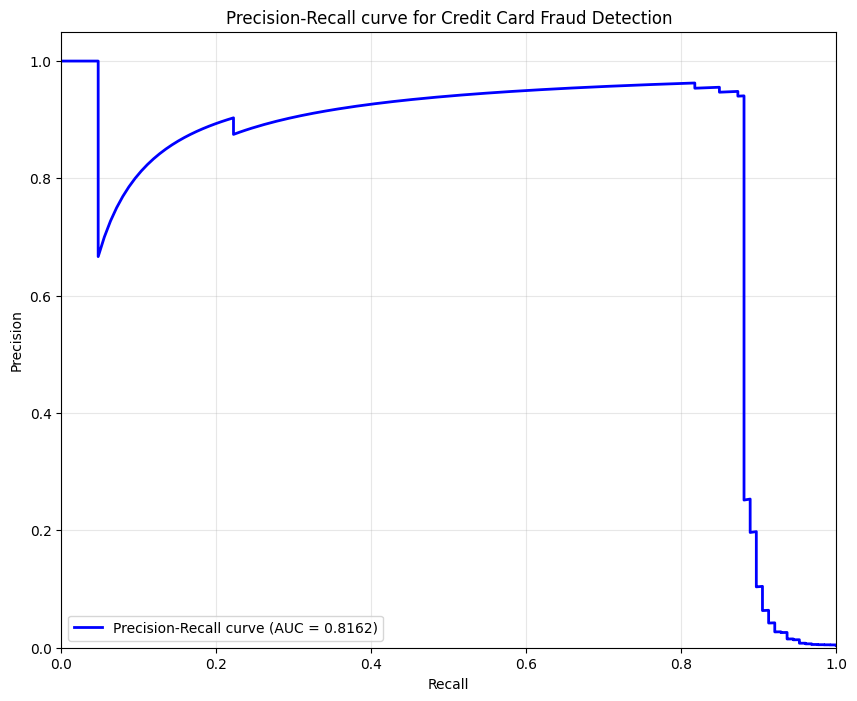

In [31]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_full, y_proba_test)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for Credit Card Fraud Detection')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

### Model Performance
- The area under the precision-recall curve (**PR AUC**) is **0.8162**
- This indicates a **strong ability** to detect fraud while minimizing false alarms.
- Our model achieves a good trade-off between **high recall** (catching more fraud) and **high precision** (reducing false flags).

### Helper Code for evaluation
We will now evaluate various key metrics like the optimal threshold, precison, recall, f1 score, and our confusion matrix

Optimal threshold: 0.4550
At this threshold:
  - Precision: 0.9407
  - Recall: 0.8810
  - F1 Score: 0.9098


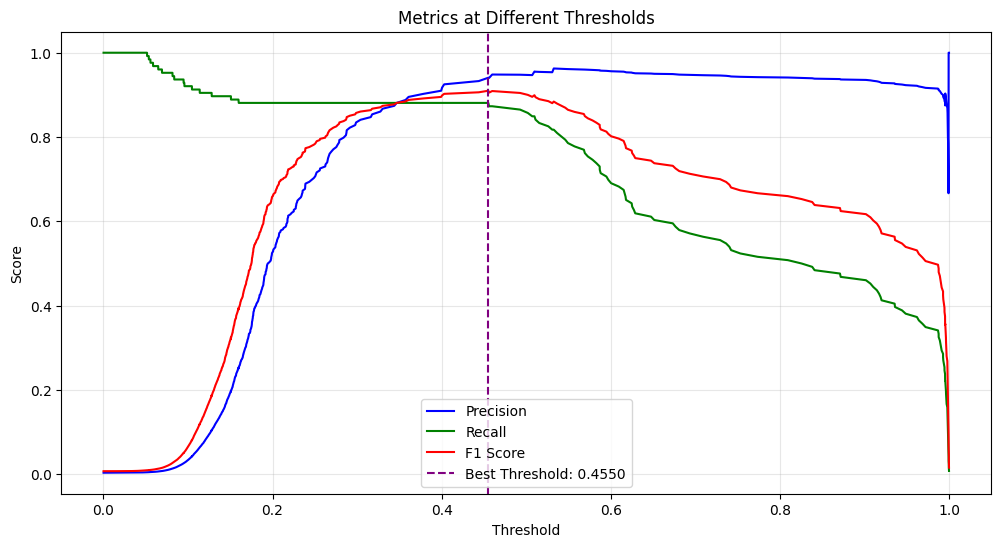

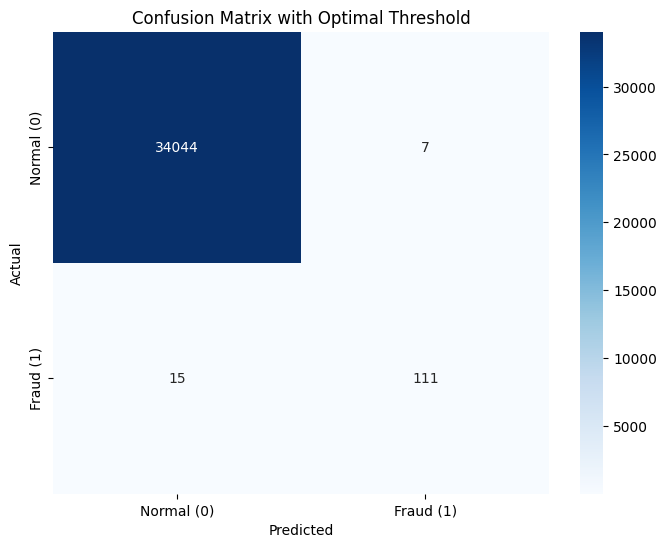

In [32]:
# Analyze different threshold values to find the optimal one

# Create dataframe to store metrics at different thresholds
threshold_metrics = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],  # precision has one more element than thresholds
    'recall': recall[:-1]        # recall has one more element than thresholds
})

# Calculate F1 score
threshold_metrics['f1_score'] = 2 * (threshold_metrics['precision'] * threshold_metrics['recall']) / \
                                  (threshold_metrics['precision'] + threshold_metrics['recall'])

# Find threshold that maximizes F1 score
best_idx = threshold_metrics['f1_score'].idxmax()
best_threshold = threshold_metrics.loc[best_idx, 'threshold']
best_f1 = threshold_metrics.loc[best_idx, 'f1_score']
best_precision = threshold_metrics.loc[best_idx, 'precision']
best_recall = threshold_metrics.loc[best_idx, 'recall']

print(f"Optimal threshold: {best_threshold:.4f}")
print(f"At this threshold:")
print(f"  - Precision: {best_precision:.4f}")
print(f"  - Recall: {best_recall:.4f}")
print(f"  - F1 Score: {best_f1:.4f}")

# Plot threshold vs metrics
plt.figure(figsize=(12, 6))
plt.plot(threshold_metrics['threshold'], threshold_metrics['precision'], label='Precision', color='blue')
plt.plot(threshold_metrics['threshold'], threshold_metrics['recall'], label='Recall', color='green')
plt.plot(threshold_metrics['threshold'], threshold_metrics['f1_score'], label='F1 Score', color='red')
plt.axvline(x=best_threshold, color='purple', linestyle='--', label=f'Best Threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Generate confusion matrix using the optimal threshold
y_pred_binary = (y_proba_test >= best_threshold).astype(int)
cm = confusion_matrix(y_test_full, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'Fraud (1)'], 
            yticklabels=['Normal (0)', 'Fraud (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimal Threshold')
plt.show()

### Insights
- The model succesfully identifies a **large portion of fraud cases (Recall = 88.1%)**
- Maintains **high precision (94.87%)**, meaning a few false alarms
- This balance is critical for our objective

In [33]:
# evaluation example (we will use unseen data)


precision, recall, thresholds = precision_recall_curve(y_test_full, y_proba_test)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test_full, y_proba_test)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

Average Precision: 0.8175
Precision-Recall AUC: 0.8162


# Final scoring function

You are welcome to explore various models and / or ensembles of different models. To facilitate evaluation, please include your final model and / or ensemble score in the following function. If you use more than more models, the function should return an *ensemble* score, e.g., the average score from all models.

We will use this function to evaluate your work on unseen data.

In [34]:
def anomaly_score(X_data):
    """
    Calculate combined anomaly score using XGBoost and Isolation Forest models
    
    Parameters:
    -----------
    X_data : array-like or pandas DataFrame
        Feature data for which to calculate anomaly scores
        
    Returns:
    --------
    array-like
        Final anomaly scores, higher values indicate higher probability of being an anomaly
    """

    X_data['Hour'] = ((X_data['Time'] // 3600) % 24).astype(int)
    X_data = X_data.drop(['Time'], axis=1)
    X_data = preprocess(X_data, kmeans_cluster)
    xgb_scores = voting_clf.predict_proba(X_data)[:, 1]
    
    return xgb_scores

In [35]:
y_test_scores = anomaly_score(X_data)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_scores)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_test_scores)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

NameError: name 'X_data' is not defined